## VaR Portofolio


=========== PORTFOLIO RISK RESULTS ===========
Mean PL           : 2,621,282,395
Std Dev           : 119,885,579,191

--- VaR 95% ---
Historical VaR95  : -167,875,535,161
Parametric VaR95  : -194,572,947,355

--- ES 95% ---
Historical ES95   : -254,903,867,346
Parametric ES95   : -244,668,237,236



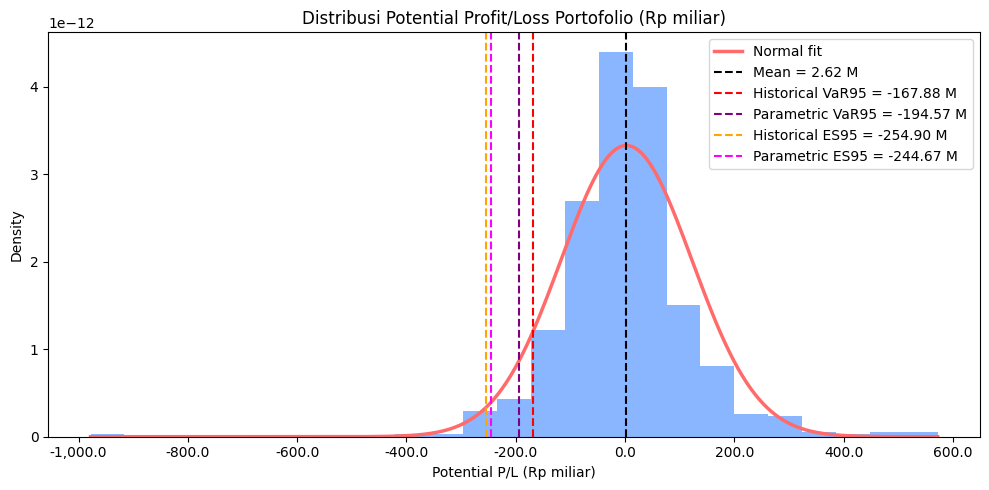

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from scipy.stats import norm

# =========================
# 1. READ DATA
# =========================

file_path = "PL_instruments.xlsx"
df = pd.read_excel(file_path)

# Adjust column names to match your Excel
FI_COL   = "PL_FI"
STK_COL  = "PL_Saham"
MF_COL   = "PL_RD"

for col in [FI_COL, STK_COL, MF_COL]:
    if col not in df.columns:
        raise ValueError(f"Kolom {col} tidak ditemukan di file Excel.")

# =========================
# 2. COMBINED PORTFOLIO PL
# =========================

df["PL_Total"] = df[FI_COL] + df[STK_COL] + df[MF_COL]
series = df["PL_Total"].dropna()

# =========================
# 3. RISK METRICS
# =========================

alpha = 0.95           # 95% VaR (left tail)
z_95 = norm.ppf(1 - alpha)   # = -1.645

mu = series.mean()
sigma = series.std(ddof=1)

# ---------- HISTORICAL VAR ----------
VaR95_hist = series.quantile(1 - alpha)

# ---------- PARAMETRIC VAR ----------
# VaR = μ + zσ (z ~ -1.645)
VaR95_param = mu + z_95 * sigma

# ---------- EXPECTED SHORTFALL (Historical) ----------
losses = -series
loss_q = np.quantile(losses, alpha)
ES95_hist = -losses[losses >= loss_q].mean()

# ---------- PARAMETRIC ES (Optional) ----------
ES95_param = mu - sigma * norm.pdf(norm.ppf(1 - alpha)) / (1 - alpha)



# =========================
# 4. PRINT RESULTS
# =========================

print("\n=========== PORTFOLIO RISK RESULTS ===========")
print(f"Mean PL           : {mu:,.0f}")
print(f"Std Dev           : {sigma:,.0f}")

print("\n--- VaR 95% ---")
print(f"Historical VaR95  : {VaR95_hist:,.0f}")
print(f"Parametric VaR95  : {VaR95_param:,.0f}")

print("\n--- ES 95% ---")
print(f"Historical ES95   : {ES95_hist:,.0f}")
print(f"Parametric ES95   : {ES95_param:,.0f}")
print("==============================================\n")


# =========================
# 5. PLOT DISTRIBUTION
# =========================

def miliar_fmt(x, pos):
    return f"{x/1e9:,.1f}"

fig, ax = plt.subplots(figsize=(10, 5))

# Histogram
ax.hist(series, bins=25, density=True, alpha=0.6, color="#3a86ff")

# Normal curve
xmin, xmax = series.min(), series.max()
x = np.linspace(xmin, xmax, 400)
y = norm.pdf(x, mu, sigma)
ax.plot(x, y, linewidth=2.5, color="#ff6b6b", label="Normal fit")

# Lines for mean and VaR
ax.axvline(mu, color="black", linestyle="--", label=f"Mean = {mu/1e9:.2f} M")
ax.axvline(VaR95_hist, color="red", linestyle="--", label=f"Historical VaR95 = {VaR95_hist/1e9:.2f} M")
ax.axvline(VaR95_param, color="purple", linestyle="--", label=f"Parametric VaR95 = {VaR95_param/1e9:.2f} M")
ax.axvline(ES95_hist, color="orange", linestyle="--", label=f"Historical ES95 = {ES95_hist/1e9:.2f} M")
ax.axvline(ES95_param, color="magenta", linestyle="--", label=f"Parametric ES95 = {ES95_param/1e9:.2f} M")

ax.xaxis.set_major_formatter(FuncFormatter(miliar_fmt))
ax.set_title("Distribusi Potential Profit/Loss Portofolio (Rp miliar)")
ax.set_xlabel("Potential P/L (Rp miliar)")
ax.set_ylabel("Density")
ax.legend()
plt.tight_layout()
plt.show()
